In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from evaluate import evaluate
from utils import img_parts_generator
from inceptionv4 import create_model
from scipy.misc import imsave
import numpy as np
import time
import os
from keras import backend as K

K.set_learning_phase(1)

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    #x = x-np.amin(x)
    #x = x/float(np.amax(x))

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    x = np.reshape(x, (299,299,3))
    #x = x/255.0
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def plot_data(img, x=None, y=None):
    implot = plt.imshow(img)
    if x is not None and y is not None:
        plt.plot(x,y,'o', marker=5)
    plt.show()

In [2]:
def dir_avail(dir_name):
    """
    Create directory if not present
    """
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [3]:
weights = 'best_weights/defrost_all_cropped_77.hdf5'
model, input_img = create_model(num_classes=500,
                     include_top=False, 
                     weights=weights,
                     return_input=True)
# this is the placeholder for the input images

Inceptionv4 Base loaded


/home/ubuntu/birdsnap_dataset/deepbirdsnap/inceptionv4.py:330: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  top_model = Model(input=inputs, output=x)
/home/ubuntu/birdsnap_dataset/deepbirdsnap/inceptionv4.py:395: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("mo..., inputs=Tensor("in...)`
  fused = Model(input=base_inputs, output=top(base(base_inputs)))


Weights loaded


In [4]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    '../cropped/validation',
    target_size=(299, 299),
    batch_size=100)

validation_eval = []
count = 0

res = model.evaluate_generator(validation_generator, 3000//100)
print(res)

Found 3000 images belonging to 500 classes.
[0.93568264842033388, 0.75899997750918069]


In [4]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

In [6]:
print(model.output)
print(model.layers[-1].layers[-1].output)
print(input_img)

Tensor("model_1/dense_1/Softmax:0", shape=(?, 500), dtype=float32)
Tensor("dense_1/Softmax:0", shape=(?, 500), dtype=float32)
Tensor("input_1:0", shape=(?, 299, 299, 3), dtype=float32)


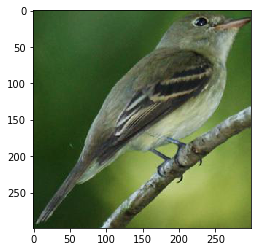

In [72]:
gen = img_parts_generator('parts_info.txt', data_dir='../cropped/validation/', batch_size=1, load_image=True, load_parts=False)
for _ in range(1):
    next(gen)
img = next(gen)[0]
plot_data(img[0])
input_img_data = img

In [119]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

img_width, img_height = 299,299

def get_vis(model, filter_index, plot=True, epochs=150, output_layer=False, img=None):
    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    if output_layer:
        loss = K.mean(model.output[:filter_index])#model.layers[:filter_index])
    else:
        #layer_output = model.layers[1].output
        layer_output = layer_dict['concatenate_1'].output
        loss = K.mean(layer_output[:, :, :,filter_index])
    #print('loss init')
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
    #print('grad init')
    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1
    if img is not None:
        input_img_data = img
    else:
        # gray image with some random noise
        input_img_data = np.random.random((1, img_width, img_height, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128
    input_img_data = 1.0/255.*input_img_data

    # we run gradient ascent for 20 steps
    for i in range(epochs):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if i%200 == 0:
            print('Current loss value:', loss_value, i)
            step*=0.95
    #     if i%50 == 0:
    #         step*=0.5
            if loss_value <= 0. and i>=400:
                # some filters get stuck to 0, we can skip them
                break
    img = deprocess_image(input_img_data[0])
    img = input_img_data[0]
    if plot:
        plot_data(img)
    return img,loss_value

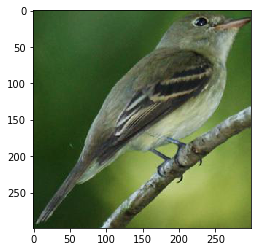

Current loss value: 0.189208 0
Current loss value: 2.20353 200
Current loss value: 2.20708 400


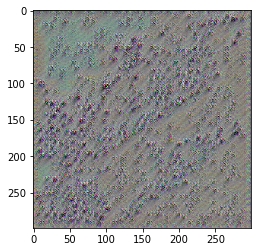

visual2/bird_concatenate_1/6.jpg
Current loss value: 2.61234 0
Current loss value: 5.21819 200
Current loss value: 5.22612 400


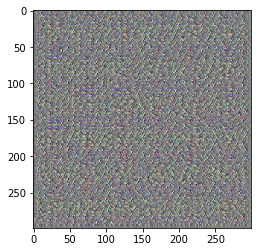

visual2/bird_concatenate_1/12.jpg
Current loss value: 1.35444 0
Current loss value: 3.89425 200
Current loss value: 3.89692 400


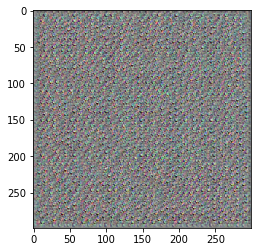

visual2/bird_concatenate_1/18.jpg
Current loss value: 3.20093 0
Current loss value: 5.65131 200
Current loss value: 5.65258 400


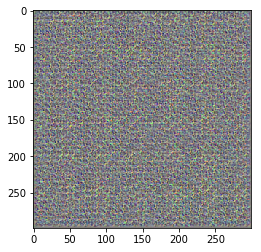

visual2/bird_concatenate_1/24.jpg


KeyboardInterrupt: 

In [120]:
visuals = []
expname = 'bird_concatenate_1'
path = 'visual2/'+expname
dir_avail(path)
plot_data(input_img_data[0])
kept_filters = []
for i in range(6,64,6):
    v,l = get_vis(model,i,output_layer=False,epochs=401,
                img=np.copy(input_img_data))
                #img=np.reshape(visuals[0],(1,299,299,3)))
    kept_filters.append((v,l))
    visuals.append(v)
    save_path = '{}/{}.jpg'.format(path,i)
    print(save_path)
    imsave(save_path, v)

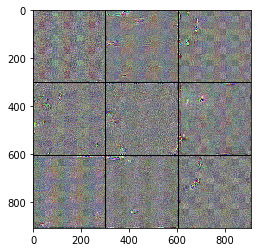

In [100]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 3
# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img
# save the result to disk
plot_data(stitched_filters)
imsave('visual2/'+expname+'.jpg' , stitched_filters)

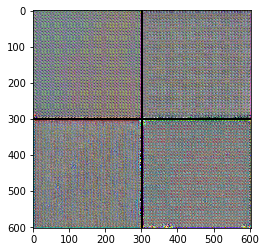